# 📈 Model Evaluation on Test Data
This notebook evaluates a trained model on unseen test data, displaying classification reports, confusion matrices, and prediction visualizations.

---

### 🔧 Imports and Configurations

In [29]:
# === Imports ===
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import logging

# === Configuration Constants ===

# Distribution strategy (IID, non-IID etc.)
DISTRIBUTION = "non-IID"
MODEL_TYPE = "standalone" # global, standalone

# Test dataset
TEST_DIR = f"../../resources/material/train-data/federated/{DISTRIBUTION}-npy/test_clients"
LABEL_CSV = f"../../resources/material/train-data/federated/{DISTRIBUTION}/test_clients/labels.csv"
LABEL_MAP = {"bad": 0, "good": 1}
REVERSE_MAP = {0: "bad", 1: "good"}
LABELS = ["Good", "Bad"]

# Model
MODEL_PATH = f"../../model/{MODEL_TYPE}_{DISTRIBUTION}_model.h5"

# Plots
PLOT_DIR = f"../../resources/plot/{MODEL_TYPE}/test-data/{DISTRIBUTION}"
CONFUSION_MATRIX_PLOT_DIR = f"{PLOT_DIR}/confusion_matrix.png"
ROC_AUC_PLOT_DIR = f"{PLOT_DIR}/roc_auc.png"
PRECISION_RECALL_PLOT_DIR = f"{PLOT_DIR}/precision_recall.png"
PREDICTION_HISTOGRAM_PLOT_DIR = f"{PLOT_DIR}/prediction_histogram.png"
PER_CLASS_ACCURACY_PLOT_DIR = f"{PLOT_DIR}/per_class_accuracy.png"
F1_THRESHOLD_PLOT_DIR = f"{PLOT_DIR}/f1_threshold.png"
F1_EPOCH_PLOT_DIR = f"{PLOT_DIR}/f1_epoch.png"
PRECISION_RECALL_F1_ISOCURVS_PLOT_DIR = f"{PLOT_DIR}/precision_recall_curve_with_f1_isocurves.png"

os.makedirs(PLOT_DIR, exist_ok=True)

# Log path
# Format: YYYY-MM-DD_HH-MM-SS
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
LOG_BASE_DIR = f"../../logs/{MODEL_TYPE}/{DISTRIBUTION}/evaluate_model_log_{timestamp}.log"

### 🧾 Logging Setup

In [30]:
# Ensure log directory exists
os.makedirs(os.path.dirname(LOG_BASE_DIR), exist_ok=True)

# Reset logging config if already set
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Setup logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[
        logging.FileHandler(LOG_BASE_DIR),
        logging.StreamHandler()
    ],
)

def log(msg):
    logging.info(msg)

log(f"=== Logs up and running @ [{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ===")


2025-07-29 18:46:42,461 [INFO] === Logs up and running @ [2025-07-29 18:46:42] ===


### 📘 Load and Preprocess Test Data

In [31]:

def load_label_mapping(label_csv=LABEL_CSV, label_map=LABEL_MAP):
    df = pd.read_csv(label_csv)
    return {
        row["filename"].replace(".wav", ".npy"): label_map[row["label"].strip().lower()]
        for _, row in df.iterrows()
    }

def load_all_training_data(base_dir):
    all_data = []
    
    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".npy"):
                data = np.load(os.path.join(root, file))
                data = data.flatten()  # ensure it's 1D per file
                all_data.append(data)
    
    all_data = np.concatenate(all_data, axis=0)
    return all_data

def load_test_data(test_dir=TEST_DIR):
    X, y, filenames = [], [], []
    label_dict = load_label_mapping()
    log(f"📂 Loading test data from: {test_dir}")
    
    for fname in os.listdir(test_dir):
        if fname.endswith(".npy") and fname in label_dict:
            try:
                features = np.load(os.path.join(test_dir, fname))
                X.append(features)
                y.append(label_dict[fname])
                filenames.append(fname)
            except Exception as e:
                log(f"❌ Failed to load {fname}: {e}")
        elif fname.endswith(".npy"):
            log(f"⚠️ Skipping {fname} — no label found.")
    
    return np.array(X), np.array(y), filenames

def normalize_features(X):
    """Normalize input features using mean and std from training set."""
    all_features = load_all_training_data(TEST_DIR)

    mean = np.mean(all_features)
    std = np.std(all_features)

    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)
    X = (X - mean) / std
    log(f"✅ Normalized features with mean={mean}, std={std}")
    return X

# === Load and Preprocess Test Data ===
X_test, y_test, filenames = load_test_data()
X_test = normalize_features(X_test)
log(f"🧪 Loaded {len(y_test)} test samples.")
log(f"📊 Class distribution: {dict(Counter(y_test))}")

2025-07-29 18:46:42,493 [INFO] 📂 Loading test data from: ../../resources/material/train-data/federated/non-IID-npy/test_clients
2025-07-29 18:46:42,693 [INFO] ✅ Normalized features with mean=-5.812836170196533, std=14.956048011779785
2025-07-29 18:46:42,694 [INFO] 🧪 Loaded 200 test samples.
2025-07-29 18:46:42,695 [INFO] 📊 Class distribution: {0: 100, 1: 100}


### 🎯 Load & Evaluate model

In [32]:
# === Load the Model ===
log(f"📦 Loading model from: {MODEL_PATH}")
model = load_model(MODEL_PATH)
log(f"✅ Model successfully loaded from: {MODEL_PATH}")

# === Evaluate ===
def evaluate_model(model, X, y, filenames, reverse_map=REVERSE_MAP):
    log("🔍 Performing predictions on test data...")
    y_pred_probs = model.predict(X, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    # Accuracy and classification report
    accuracy = accuracy_score(y, y_pred)
    log(f"\n📊 Accuracy: {accuracy*100:.2f}%")
    
    report = classification_report(y, y_pred, target_names=["bad", "good"])
    log(f"\n📄 Classification Report:\n{report}")

    # Per-sample results
    log("\n🔬 Prediction Details:")
    for fname, true, pred in zip(filenames, y, y_pred):
        status = "✅" if true == pred else "❌"
        log(f"{status} {fname} → True: {reverse_map[true]}, Predicted: {reverse_map[pred]}")

    return y_pred

# Execute evaluation
y_pred = evaluate_model(model, X_test, y_test, filenames)

log(f"✅ Evaluation complete.")


2025-07-29 18:46:42,706 [INFO] 📦 Loading model from: ../../model/standalone_non-IID_model.h5
2025-07-29 18:46:42,873 [INFO] ✅ Model successfully loaded from: ../../model/standalone_non-IID_model.h5
2025-07-29 18:46:42,874 [INFO] 🔍 Performing predictions on test data...
2025-07-29 18:46:42,980 [INFO] 
📊 Accuracy: 99.00%
2025-07-29 18:46:42,988 [INFO] 
📄 Classification Report:
              precision    recall  f1-score   support

         bad       0.98      1.00      0.99       100
        good       1.00      0.98      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200

2025-07-29 18:46:42,988 [INFO] 
🔬 Prediction Details:
2025-07-29 18:46:42,989 [INFO] ✅ bad_tap_604_aug_592.npy → True: bad, Predicted: bad
2025-07-29 18:46:42,990 [INFO] ✅ bad_tap_1048_org.npy → True: bad, Predicted: bad
2025-07-29 18:46:42,990 [INFO] ✅ good_tap_679_aug_1404.npy → True: good, P

### 📊 Confusion Matrix Plot

2025-07-29 18:46:43,201 [INFO] 
🧮 Generating confusion matrix @ [2025-07-29 18:46:43]
2025-07-29 18:46:43,205 [INFO] 🔢 Confusion Matrix:
[[100, 0], [2, 98]]


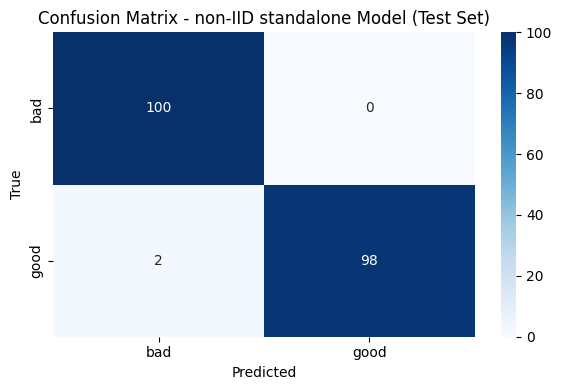

2025-07-29 18:46:43,489 [INFO] 📸 Confusion matrix plot saved to: ../../resources/plot/standalone/test-data/non-IID/confusion_matrix.png
2025-07-29 18:46:43,490 [INFO] ✅ Confusion matrix plotting completed.



In [33]:
# === Confusion Matrix Plot with Logging ===
def plot_confusion_matrix(y_true, y_pred, title, save_path):
    log(f"\n🧮 Generating confusion matrix @ [{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}]")
    cm = confusion_matrix(y_true, y_pred)

    log(f"🔢 Confusion Matrix:\n{cm.tolist()}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["bad", "good"], yticklabels=["bad", "good"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()

    log(f"📸 Confusion matrix plot saved to: {save_path}")
    log(f"✅ Confusion matrix plotting completed.\n")

# === Call the Function ===
plot_confusion_matrix(
    y_true=y_test,
    y_pred=y_pred,
    title=f"Confusion Matrix - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)",
    save_path=CONFUSION_MATRIX_PLOT_DIR
)


### 📊 ROC Curve 

2025-07-29 18:46:43,502 [INFO] 🚀 Generating ROC AUC Curve from test set predictions...


7/7 [==============================] - 0s 1ms/step


2025-07-29 18:46:43,562 [INFO] 
📈 ROC Curve Evaluation Started...
2025-07-29 18:46:43,565 [INFO]   • AUC Score: 0.9983
2025-07-29 18:46:43,565 [INFO]   • Plot will be saved to: ../../resources/plot/standalone/test-data/non-IID/roc_auc.png
2025-07-29 18:46:43,664 [INFO] ✅ ROC curve plot saved successfully.


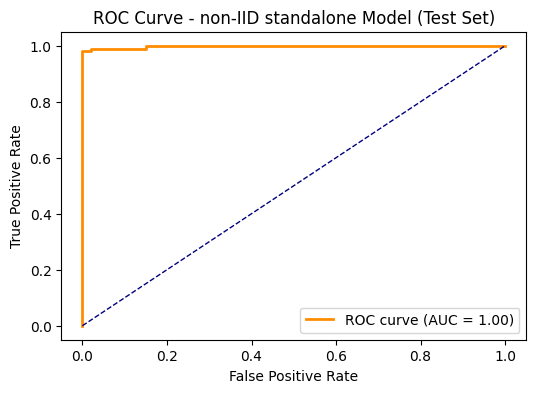

2025-07-29 18:46:43,753 [INFO] ✅ ROC Curve Evaluation Completed.



In [34]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc(y_true, y_pred_prob, save_path=None):
    log("\n📈 ROC Curve Evaluation Started...")

    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    log(f"  • AUC Score: {roc_auc:.4f}")
    if save_path:
        log(f"  • Plot will be saved to: {save_path}")
    else:
        log("  • No save path provided. Displaying plot only.")

    # Plot ROC
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.legend(loc="lower right")

    if save_path:
        plt.savefig(save_path)
        log("✅ ROC curve plot saved successfully.")
    plt.show()

    log("✅ ROC Curve Evaluation Completed.\n")

# === Predict Probabilities and Plot ROC ===
log("🚀 Generating ROC AUC Curve from test set predictions...")
y_pred_probs = model.predict(X_test).flatten()
plot_roc(y_test, y_pred_probs, ROC_AUC_PLOT_DIR)


### 📊  Precision-Recall Curve

2025-07-29 18:46:43,762 [INFO] 🚀 Generating Precision-Recall Curve from test set predictions...
2025-07-29 18:46:43,763 [INFO] 
📊 Precision-Recall Evaluation Started...
2025-07-29 18:46:43,765 [INFO]   • Average Precision: 0.8453
2025-07-29 18:46:43,766 [INFO]   • Average Recall: 0.7479
2025-07-29 18:46:43,768 [INFO]   • Saving Precision-Recall plot to: ../../resources/plot/standalone/test-data/non-IID/precision_recall.png
2025-07-29 18:46:43,866 [INFO] ✅ Precision-Recall plot saved successfully.


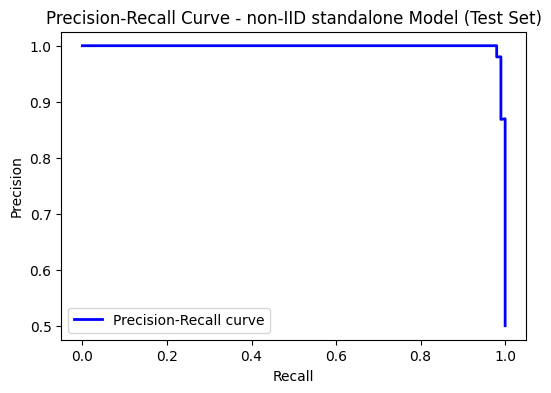

2025-07-29 18:46:43,946 [INFO] ✅ Precision-Recall Evaluation Completed.



In [35]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall(y_true, y_pred_prob, save_path=None):
    log("\n📊 Precision-Recall Evaluation Started...")

    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)

    avg_precision = precision.mean()
    avg_recall = recall.mean()
    log(f"  • Average Precision: {avg_precision:.4f}")
    log(f"  • Average Recall: {avg_recall:.4f}")
    log(f"  • Saving Precision-Recall plot to: {save_path}" if save_path else "  • No save path provided; displaying plot only.")

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, lw=2, color='blue', label="Precision-Recall curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.legend(loc="lower left")
    if save_path:
        plt.savefig(save_path)
        log("✅ Precision-Recall plot saved successfully.")
    plt.show()

    log("✅ Precision-Recall Evaluation Completed.\n")

# === Plot Precision-Recall Curve ===
log("🚀 Generating Precision-Recall Curve from test set predictions...")
plot_precision_recall(y_test, y_pred_probs, PRECISION_RECALL_PLOT_DIR)


### 📊  Prediction Score Distribution

2025-07-29 18:46:43,954 [INFO] 🚀 Generating Prediction Histogram from test set predictions...


7/7 [==============================] - 0s 2ms/step


2025-07-29 18:46:44,032 [INFO] 
📊 Prediction Score Distribution Plot Started...
2025-07-29 18:46:44,249 [INFO] ✅ Histogram saved to: ../../resources/plot/standalone/test-data/non-IID/prediction_histogram.png


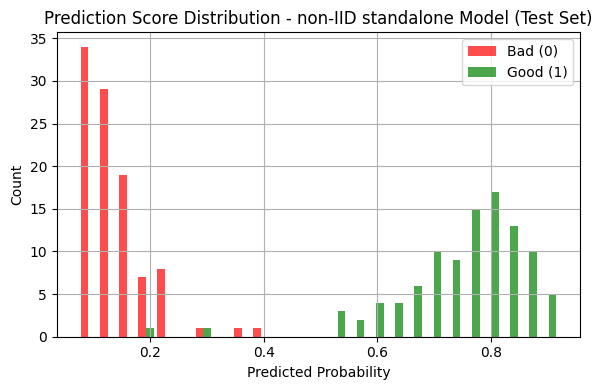

2025-07-29 18:46:44,368 [INFO] ✅ Prediction Score Distribution Plot Completed.



In [36]:
# === Predicted probabilities from model ===
log("🚀 Generating Prediction Histogram from test set predictions...")
y_probs = model.predict(X_test).flatten()

def plot_prediction_histogram(y_probs, y_true, save_path=None):
    log("\n📊 Prediction Score Distribution Plot Started...")

    # Plot histogram
    plt.figure(figsize=(6, 4))
    plt.hist([y_probs[y_true == 0], y_probs[y_true == 1]],
             bins=25, label=['Bad (0)', 'Good (1)'], color=['red', 'green'], alpha=0.7)
    plt.xlabel("Predicted Probability")
    plt.ylabel("Count")
    plt.title(f"Prediction Score Distribution - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save if path is provided
    if save_path:
        plt.savefig(save_path)
        log(f"✅ Histogram saved to: {save_path}")
    else:
        log("ℹ️ No save path provided; displaying histogram only.")

    plt.show()
    log("✅ Prediction Score Distribution Plot Completed.\n")

# === Run the plot ===
plot_prediction_histogram(y_probs, y_test, PREDICTION_HISTOGRAM_PLOT_DIR)


### 📊  Per-Class Accuracy

2025-07-29 18:46:44,376 [INFO] 🚀 Generating Per-Class Accuracy Plot...
2025-07-29 18:46:44,377 [INFO] 
📊 Per-Class Accuracy Evaluation Started...
2025-07-29 18:46:44,378 [INFO]   • bad Accuracy: 1.0000
2025-07-29 18:46:44,379 [INFO]   • good Accuracy: 0.9800
/var/folders/9_/0r_f3kw13_zg23k72mwhdmp558319r/T/ipykernel_76420/3464814903.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=accuracies, palette="Set2")
2025-07-29 18:46:44,480 [INFO] 📁 Plot saved to: ../../resources/plot/standalone/test-data/non-IID/per_class_accuracy.png


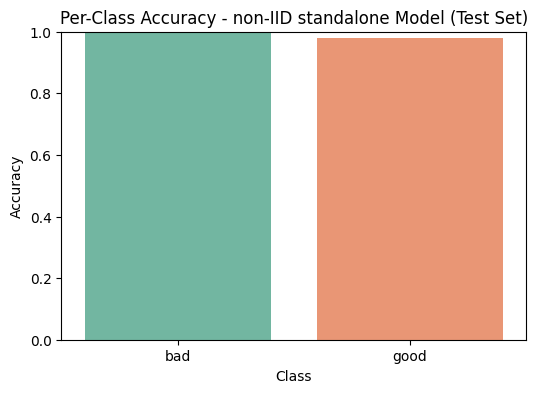

2025-07-29 18:46:44,607 [INFO] ✅ Per-Class Accuracy Evaluation Completed.



In [37]:
def plot_per_class_accuracy(y_true, y_pred, save_path=None):
    log("\n📊 Per-Class Accuracy Evaluation Started...")

    labels = np.unique(y_true)
    accuracies = [
        np.mean(y_pred[y_true == label] == label) for label in labels
    ]
    label_names = [REVERSE_MAP[l] for l in labels]

    for label, acc in zip(label_names, accuracies):
        log(f"  • {label} Accuracy: {acc:.4f}")

    # Plotting
    plt.figure(figsize=(6, 4))
    sns.barplot(x=label_names, y=accuracies, palette="Set2")
    plt.ylim(0, 1)
    plt.title(f"Per-Class Accuracy - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.ylabel("Accuracy")
    plt.xlabel("Class")

    if save_path:
        plt.savefig(save_path)
        log(f"📁 Plot saved to: {save_path}")
    else:
        log("ℹ️ No save path provided; showing plot only.")

    plt.show()
    log("✅ Per-Class Accuracy Evaluation Completed.\n")

# === Call the function ===
log("🚀 Generating Per-Class Accuracy Plot...")
plot_per_class_accuracy(y_test, y_pred, PER_CLASS_ACCURACY_PLOT_DIR)


### 📊  F1 Score vs Threshold

2025-07-29 18:46:44,630 [INFO] 🚀 Plotting F1 Score vs Threshold...
2025-07-29 18:46:44,632 [INFO] 
📊 F1 Score vs Threshold Plot Started...
2025-07-29 18:46:44,775 [INFO]   • Best F1 Score: 0.9899 at Threshold = 0.39
2025-07-29 18:46:44,913 [INFO] ✅ F1 Threshold Plot saved to: ../../resources/plot/standalone/test-data/non-IID/f1_threshold.png


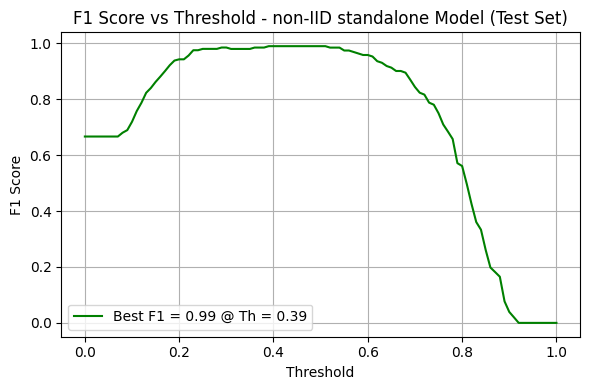

2025-07-29 18:46:45,012 [INFO] ✅ F1 Score vs Threshold Plot Completed.



In [38]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt

def plot_f1_vs_threshold(y_true, y_probs, save_path=None):
    log("\n📊 F1 Score vs Threshold Plot Started...")

    thresholds = np.arange(0.0, 1.01, 0.01)
    f1_scores = [f1_score(y_true, y_probs >= t) for t in thresholds]

    # Log best F1 score and corresponding threshold
    best_idx = int(np.argmax(f1_scores))
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    log(f"  • Best F1 Score: {best_f1:.4f} at Threshold = {best_threshold:.2f}")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(thresholds, f1_scores, color='green', label=f'Best F1 = {best_f1:.2f} @ Th = {best_threshold:.2f}')
    plt.xlabel("Threshold")
    plt.ylabel("F1 Score")
    plt.title(f"F1 Score vs Threshold - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    # Save or show plot
    if save_path:
        plt.savefig(save_path)
        log(f"✅ F1 Threshold Plot saved to: {save_path}")
    else:
        log("ℹ️ No save path provided; displaying plot only.")

    plt.show()
    log("✅ F1 Score vs Threshold Plot Completed.\n")

# === Run Plot ===
log("🚀 Plotting F1 Score vs Threshold...")
plot_f1_vs_threshold(y_test, y_pred_probs, F1_THRESHOLD_PLOT_DIR)

### 📊  Validation F1 Score over Epochs

2025-07-29 18:46:45,023 [INFO] 
🧪 Splitting test set into train/val for F1 evaluation...
2025-07-29 18:46:45,028 [INFO]   • X_train shape: (160, 4096), X_val shape: (40, 4096)
2025-07-29 18:46:45,028 [INFO]   • y_train shape: (160,), y_val shape: (40,)
2025-07-29 18:46:45,029 [INFO] ✅ Test split completed.
2025-07-29 18:46:45,030 [INFO] 
🚀 Starting model training with F1 tracking...


Epoch 1/30
2/2 [==============================] - 0s 2ms/steposs: 0.2528 - accuracy: 0.93


2025-07-29 18:46:45,781 [INFO] 📊 Epoch 1 — Validation F1 Score: 0.9189


5/5 [==============================] - 1s 62ms/step - loss: 0.2598 - accuracy: 0.9187 - val_loss: 0.1588 - val_accuracy: 0.9250
Epoch 2/30
2/2 [==============================] - 0s 2ms/steposs: 0.3633 - accuracy: 0.81


2025-07-29 18:46:45,919 [INFO] 📊 Epoch 2 — Validation F1 Score: 0.9189


5/5 [==============================] - 0s 32ms/step - loss: 0.3151 - accuracy: 0.8500 - val_loss: 0.2254 - val_accuracy: 0.9250
Epoch 3/30
2/2 [==============================] - 0s 2ms/steposs: 0.3446 - accuracy: 0.84


2025-07-29 18:46:46,065 [INFO] 📊 Epoch 3 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 34ms/step - loss: 0.2882 - accuracy: 0.8562 - val_loss: 0.0899 - val_accuracy: 1.0000
Epoch 4/30
2/2 [==============================] - 0s 3ms/steposs: 0.2213 - accuracy: 0.93


2025-07-29 18:46:46,204 [INFO] 📊 Epoch 4 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 32ms/step - loss: 0.2305 - accuracy: 0.9250 - val_loss: 0.0858 - val_accuracy: 1.0000
Epoch 5/30
2/2 [==============================] - 0s 2ms/steposs: 0.2307 - accuracy: 0.93


2025-07-29 18:46:46,347 [INFO] 📊 Epoch 5 — Validation F1 Score: 0.9744


5/5 [==============================] - 0s 33ms/step - loss: 0.1896 - accuracy: 0.9563 - val_loss: 0.1115 - val_accuracy: 0.9750
Epoch 6/30
2/2 [==============================] - 0s 2ms/steposs: 0.2886 - accuracy: 0.93


2025-07-29 18:46:46,492 [INFO] 📊 Epoch 6 — Validation F1 Score: 0.9744


5/5 [==============================] - 0s 33ms/step - loss: 0.2163 - accuracy: 0.9125 - val_loss: 0.1082 - val_accuracy: 0.9750
Epoch 7/30
2/2 [==============================] - 0s 2ms/steposs: 0.1637 - accuracy: 0.95


2025-07-29 18:46:46,657 [INFO] 📊 Epoch 7 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 38ms/step - loss: 0.1637 - accuracy: 0.9563 - val_loss: 0.0676 - val_accuracy: 1.0000
Epoch 8/30
2/2 [==============================] - 0s 2ms/steposs: 0.1050 - accuracy: 0.96


2025-07-29 18:46:46,815 [INFO] 📊 Epoch 8 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 36ms/step - loss: 0.1353 - accuracy: 0.9563 - val_loss: 0.0544 - val_accuracy: 1.0000
Epoch 9/30
2/2 [==============================] - 0s 2ms/steposs: 0.1547 - accuracy: 0.95


2025-07-29 18:46:46,989 [INFO] 📊 Epoch 9 — Validation F1 Score: 0.9744


5/5 [==============================] - 0s 39ms/step - loss: 0.1547 - accuracy: 0.9563 - val_loss: 0.0750 - val_accuracy: 0.9750
Epoch 10/30
2/2 [==============================] - 0s 3ms/steposs: 0.1556 - accuracy: 0.96


2025-07-29 18:46:47,187 [INFO] 📊 Epoch 10 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 45ms/step - loss: 0.1395 - accuracy: 0.9688 - val_loss: 0.0699 - val_accuracy: 1.0000
Epoch 11/30
2/2 [==============================] - 0s 2ms/steposs: 0.1143 - accuracy: 0.96


2025-07-29 18:46:47,409 [INFO] 📊 Epoch 11 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 40ms/step - loss: 0.1143 - accuracy: 0.9688 - val_loss: 0.0513 - val_accuracy: 1.0000
Epoch 12/30
2/2 [==============================] - 0s 2ms/steposs: 0.1392 - accuracy: 0.96


2025-07-29 18:46:47,581 [INFO] 📊 Epoch 12 — Validation F1 Score: 0.9744


5/5 [==============================] - 0s 39ms/step - loss: 0.1392 - accuracy: 0.9688 - val_loss: 0.0731 - val_accuracy: 0.9750
Epoch 13/30
2/2 [==============================] - 0s 3ms/steposs: 0.1315 - accuracy: 0.96


2025-07-29 18:46:47,754 [INFO] 📊 Epoch 13 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 40ms/step - loss: 0.1315 - accuracy: 0.9625 - val_loss: 0.0518 - val_accuracy: 1.0000
Epoch 14/30
2/2 [==============================] - 0s 2ms/steposs: 0.1096 - accuracy: 0.98


2025-07-29 18:46:47,935 [INFO] 📊 Epoch 14 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 41ms/step - loss: 0.1096 - accuracy: 0.9812 - val_loss: 0.0450 - val_accuracy: 1.0000
Epoch 15/30
2/2 [==============================] - 0s 2ms/steposs: 0.0941 - accuracy: 0.98


2025-07-29 18:46:48,098 [INFO] 📊 Epoch 15 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 37ms/step - loss: 0.0941 - accuracy: 0.9812 - val_loss: 0.0408 - val_accuracy: 1.0000
Epoch 16/30
2/2 [==============================] - 0s 2ms/steposs: 0.1180 - accuracy: 0.96


2025-07-29 18:46:48,258 [INFO] 📊 Epoch 16 — Validation F1 Score: 0.9744


5/5 [==============================] - 0s 37ms/step - loss: 0.1180 - accuracy: 0.9625 - val_loss: 0.0481 - val_accuracy: 0.9750
Epoch 17/30
2/2 [==============================] - 0s 2ms/steposs: 0.1070 - accuracy: 0.96


2025-07-29 18:46:48,402 [INFO] 📊 Epoch 17 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 33ms/step - loss: 0.0850 - accuracy: 0.9688 - val_loss: 0.0296 - val_accuracy: 1.0000
Epoch 18/30
2/2 [==============================] - 0s 2ms/steposs: 0.1584 - accuracy: 0.93


2025-07-29 18:46:48,541 [INFO] 📊 Epoch 18 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 31ms/step - loss: 0.1103 - accuracy: 0.9625 - val_loss: 0.0284 - val_accuracy: 1.0000
Epoch 19/30
2/2 [==============================] - 0s 2ms/steposs: 0.0780 - accuracy: 0.96


2025-07-29 18:46:48,678 [INFO] 📊 Epoch 19 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 32ms/step - loss: 0.0848 - accuracy: 0.9750 - val_loss: 0.0380 - val_accuracy: 1.0000
Epoch 20/30
2/2 [==============================] - 0s 2ms/steposs: 0.0683 - accuracy: 1.00


2025-07-29 18:46:48,826 [INFO] 📊 Epoch 20 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 34ms/step - loss: 0.0851 - accuracy: 0.9750 - val_loss: 0.0386 - val_accuracy: 1.0000
Epoch 21/30
2/2 [==============================] - 0s 2ms/steposs: 0.1168 - accuracy: 0.96


2025-07-29 18:46:48,969 [INFO] 📊 Epoch 21 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 32ms/step - loss: 0.1311 - accuracy: 0.9500 - val_loss: 0.0301 - val_accuracy: 1.0000
Epoch 22/30
2/2 [==============================] - 0s 2ms/steposs: 0.0685 - accuracy: 1.00


2025-07-29 18:46:49,108 [INFO] 📊 Epoch 22 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 32ms/step - loss: 0.1239 - accuracy: 0.9625 - val_loss: 0.0290 - val_accuracy: 1.0000
Epoch 23/30
2/2 [==============================] - 0s 2ms/steposs: 0.0428 - accuracy: 1.00


2025-07-29 18:46:49,246 [INFO] 📊 Epoch 23 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 32ms/step - loss: 0.1143 - accuracy: 0.9688 - val_loss: 0.0412 - val_accuracy: 1.0000
Epoch 24/30
2/2 [==============================] - 0s 2ms/steposs: 0.0779 - accuracy: 0.96


2025-07-29 18:46:49,386 [INFO] 📊 Epoch 24 — Validation F1 Score: 0.9744


5/5 [==============================] - 0s 32ms/step - loss: 0.0941 - accuracy: 0.9750 - val_loss: 0.0886 - val_accuracy: 0.9750
Epoch 25/30
2/2 [==============================] - 0s 2ms/steposs: 0.0662 - accuracy: 1.00


2025-07-29 18:46:49,525 [INFO] 📊 Epoch 25 — Validation F1 Score: 0.9756


5/5 [==============================] - 0s 32ms/step - loss: 0.1033 - accuracy: 0.9750 - val_loss: 0.0507 - val_accuracy: 0.9750
Epoch 26/30
2/2 [==============================] - 0s 2ms/steposs: 0.1669 - accuracy: 0.90


2025-07-29 18:46:49,664 [INFO] 📊 Epoch 26 — Validation F1 Score: 0.9744


5/5 [==============================] - 0s 32ms/step - loss: 0.0944 - accuracy: 0.9688 - val_loss: 0.0476 - val_accuracy: 0.9750
Epoch 27/30
2/2 [==============================] - 0s 2ms/steposs: 0.0927 - accuracy: 0.96


2025-07-29 18:46:49,871 [INFO] 📊 Epoch 27 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 37ms/step - loss: 0.0927 - accuracy: 0.9688 - val_loss: 0.0242 - val_accuracy: 1.0000
Epoch 28/30
2/2 [==============================] - 0s 3ms/steposs: 0.0943 - accuracy: 0.96


2025-07-29 18:46:50,028 [INFO] 📊 Epoch 28 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 36ms/step - loss: 0.0982 - accuracy: 0.9625 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 29/30
2/2 [==============================] - 0s 2ms/steposs: 0.0691 - accuracy: 0.98


2025-07-29 18:46:50,205 [INFO] 📊 Epoch 29 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 39ms/step - loss: 0.0669 - accuracy: 0.9875 - val_loss: 0.0438 - val_accuracy: 1.0000
Epoch 30/30
2/2 [==============================] - 0s 2ms/steposs: 0.0572 - accuracy: 0.96


2025-07-29 18:46:50,349 [INFO] 📊 Epoch 30 — Validation F1 Score: 1.0000


5/5 [==============================] - 0s 32ms/step - loss: 0.0916 - accuracy: 0.9688 - val_loss: 0.0271 - val_accuracy: 1.0000


2025-07-29 18:46:50,351 [INFO] ✅ Model training completed.
2025-07-29 18:46:50,352 [INFO] 
📈 Plotting F1 score over epochs...
2025-07-29 18:46:50,500 [INFO] ✅ F1 score plot saved at: ../../resources/plot/standalone/test-data/non-IID/f1_epoch.png


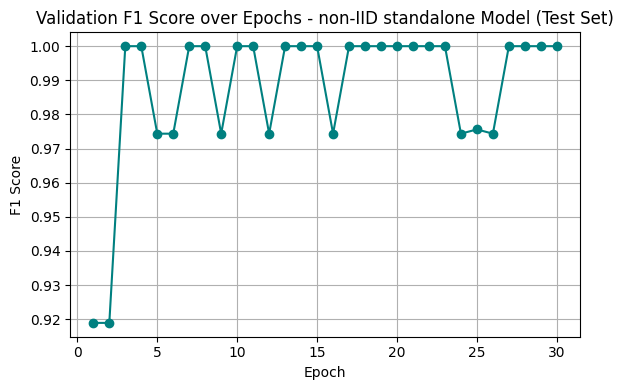

2025-07-29 18:46:50,595 [INFO] ✅ F1 score plotting complete.



In [39]:
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

# === Split Test Set for F1 Evaluation ===
log("\n🧪 Splitting test set into train/val for F1 evaluation...")
X_train, X_val, y_train, y_val = train_test_split(
    X_test, y_test, test_size=0.2, random_state=42, stratify=y_test
)
log(f"  • X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")
log(f"  • y_train shape: {y_train.shape}, y_val shape: {y_val.shape}")
log("✅ Test split completed.")

# === Custom Callback for F1 Logging ===
class F1History(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.f1_scores = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred_probs = self.model.predict(self.X_val).flatten()
        y_pred = (y_pred_probs >= 0.5).astype(int)
        f1 = f1_score(self.y_val, y_pred)
        self.f1_scores.append(f1)
        log(f"📊 Epoch {epoch + 1} — Validation F1 Score: {f1:.4f}")

# === Train Model with F1 Tracking ===
log("\n🚀 Starting model training with F1 tracking...")
f1_callback = F1History(X_val, y_val)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[f1_callback]
)
log("✅ Model training completed.")

# === Plotting F1 Over Epochs ===
def plot_f1_over_epochs(f1_scores, save_path=None):
    log("\n📈 Plotting F1 score over epochs...")
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o', color='teal')
    plt.title(f"Validation F1 Score over Epochs - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        log(f"✅ F1 score plot saved at: {save_path}")
    else:
        log("⚠️ No save path provided; showing plot only.")
    plt.show()
    log("✅ F1 score plotting complete.\n")

# === Run the Plotting ===
plot_f1_over_epochs(f1_callback.f1_scores, F1_EPOCH_PLOT_DIR)


### 📊  Precision-Recall Curve

2025-07-29 18:46:50,604 [INFO] 🚀 Generating Precision-Recall Curve from test set predictions...
2025-07-29 18:46:50,605 [INFO] 
📈 Precision-Recall Curve Evaluation Started...
2025-07-29 18:46:50,606 [INFO]   • Average Precision: 0.8453
2025-07-29 18:46:50,608 [INFO]   • Average Recall: 0.7479
2025-07-29 18:46:50,609 [INFO]   • Saving Precision-Recall plot to: ../../resources/plot/standalone/test-data/non-IID/precision_recall.png
2025-07-29 18:46:50,695 [INFO] ✅ Precision-Recall plot saved successfully.


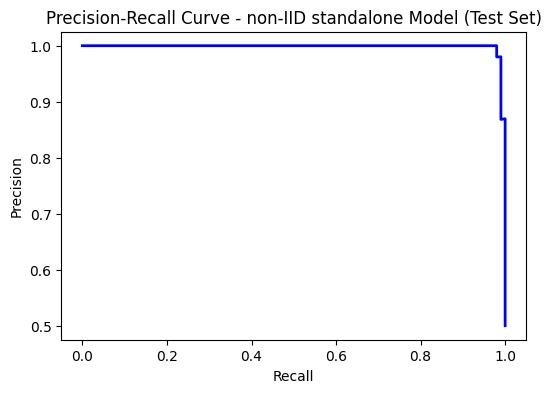

2025-07-29 18:46:50,772 [INFO] ✅ Precision-Recall Evaluation Completed.



In [40]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_precision_recall(y_true, y_pred_prob, save_path=None):
    log("\n📈 Precision-Recall Curve Evaluation Started...")

    # Compute precision-recall
    precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
    
    # Log summary metrics
    avg_precision = precision.mean()
    avg_recall = recall.mean()
    log(f"  • Average Precision: {avg_precision:.4f}")
    log(f"  • Average Recall: {avg_recall:.4f}")
    log(f"  • Saving Precision-Recall plot to: {save_path}" if save_path else "  • No save path provided; displaying plot only.")

    # Plot
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, lw=2, color='blue')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    if save_path:
        plt.savefig(save_path)
        log("✅ Precision-Recall plot saved successfully.")
    plt.show()

    log("✅ Precision-Recall Evaluation Completed.\n")

# === Call Precision-Recall Curve ===
log("🚀 Generating Precision-Recall Curve from test set predictions...")
plot_precision_recall(y_test, y_pred_probs, PRECISION_RECALL_PLOT_DIR)


### 📊  Precision-Recall Curve with F1 Isocurves

2025-07-29 18:46:50,782 [INFO] 🔍 Starting Precision-Recall Curve Evaluation...
2025-07-29 18:46:50,787 [INFO] 📊 Test set split into validation set for evaluation.
2025-07-29 18:46:50,788 [INFO] 🤖 Predicting probabilities using the trained model...


2/2 [==============================] - 0s 2ms/step


2025-07-29 18:46:50,849 [INFO] ✅ Prediction completed.
2025-07-29 18:46:50,850 [INFO] 📈 Generating Precision-Recall Curve and F1 Isocurves...


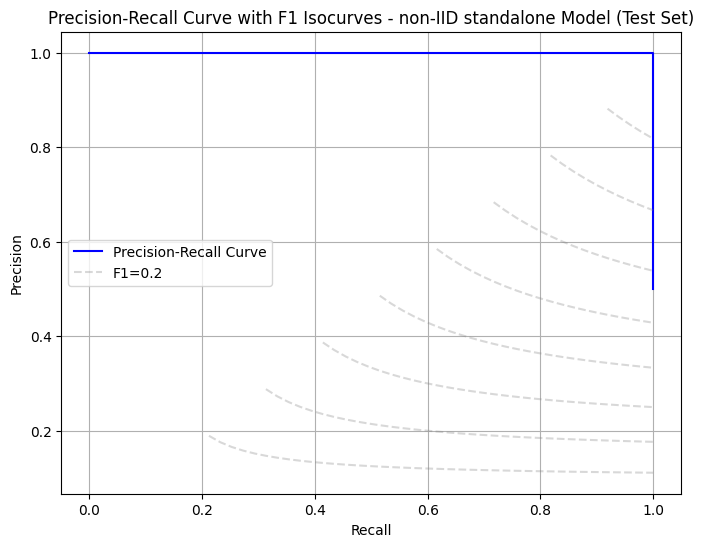

2025-07-29 18:46:51,013 [INFO] ✅ Precision-Recall Curve and F1 Isocurves displayed successfully.
2025-07-29 18:46:51,014 [INFO] 🏁 Precision-Recall Curve Evaluation Completed.



In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split

log("🔍 Starting Precision-Recall Curve Evaluation...")

# Split X_test and y_test into validation to simulate realistic conditions
X_train, X_val, y_train, y_val = train_test_split(
    X_test, y_test, test_size=0.2, random_state=42, stratify=y_test
)
log("📊 Test set split into validation set for evaluation.")

def plot_pr_with_f1_isocurves(y_true, y_probs):
    log("📈 Generating Precision-Recall Curve and F1 Isocurves...")

    precision, recall, _ = precision_recall_curve(y_true, y_probs)

    plt.figure(figsize=(8, 6))

    # 🔷 PR Curve
    plt.plot(recall, precision, color="blue", label="Precision-Recall Curve")

    # 🟠 F1 Isocurves
    f_scores = np.linspace(0.2, 0.9, num=8)
    for f in f_scores:
        x = np.linspace(0.01, 1)
        y = (f * x) / (2 * x - f + 1e-9)
        y[x < f] = np.nan  # avoid invalid values
        plt.plot(x, y, color="gray", alpha=0.3, linestyle="--", label=f"F1={f:.1f}" if f == f_scores[0] else None)

    # 🧭 Labels & Legend
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve with F1 Isocurves - {DISTRIBUTION} {MODEL_TYPE} Model (Test Set)")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

    log("✅ Precision-Recall Curve and F1 Isocurves displayed successfully.")

# Predict probabilities on the validation set
log("🤖 Predicting probabilities using the trained model...")
y_probs = model.predict(X_val).ravel()
log("✅ Prediction completed.")

# Plot the PR curve with F1 isocurves
plot_pr_with_f1_isocurves(y_val, y_probs)

log("🏁 Precision-Recall Curve Evaluation Completed.\n")
